In [27]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [28]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f: # opens the style.json file
    style: dict = json.load(f) # loads as a dictionary object

In [29]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
# TODO: replace filename with the name of your data file
tga_raw_data_filename: str ='ExpDat_2024_03_11_PS_P40042_Mn_1200_350C_isotherm.csv'
ms_raw_data_filename: str ='ExpDat_2024_03_11_PS_P40042_Mn_1200_350C_isotherm-aeolos.csv'
tga_raw_data_filename_2: str ='ExpDat_2024_03_13_PS-SCF3_P40042_Mn_1200_350C_isot.csv'
ms_raw_data_filename_2: str ='ExpDat_2024_03_13_PS-SCF3_P40042_Mn_1200_350C_isot-aeolos.csv'

# Tell program to read the data
tga_raw_data: pd.DataFrame = pd.read_csv(tga_raw_data_filename, encoding="iso-8859-1", on_bad_lines='warn', skiprows=38) # read data into a pandas dataframe
ms_raw_data: pd.DataFrame = pd.read_csv(ms_raw_data_filename, encoding="iso-8859-1", on_bad_lines='skip', skiprows=28) # read data into a pandas dataframe
tga_raw_data_2: pd.DataFrame = pd.read_csv(tga_raw_data_filename_2, encoding="iso-8859-1", on_bad_lines='warn', skiprows=38) # read data into a pandas dataframe
ms_raw_data_2: pd.DataFrame = pd.read_csv(ms_raw_data_filename_2, encoding="iso-8859-1", on_bad_lines='skip', skiprows=28) # read data into a pandas dataframe
# Output data
# tga_raw_data
# ms_raw_data
print(tga_raw_data.columns, ms_raw_data.columns)

Index(['##Temp./°C', 'Time/min', 'Mass/%', 'Segment'], dtype='object') Index(['##Temp./°C', 'Time/min', 'QMID(s:1|m:15)/A', 'QMID(s:1|m:16)/A',
       'QMID(s:1|m:17)/A', 'QMID(s:1|m:18)/A', 'QMID(s:1|m:19)/A',
       'QMID(s:1|m:20)/A', 'QMID(s:1|m:21)/A', 'QMID(s:1|m:22)/A',
       ...
       'QMID(s:1|m:141)/A', 'QMID(s:1|m:142)/A', 'QMID(s:1|m:143)/A',
       'QMID(s:1|m:144)/A', 'QMID(s:1|m:145)/A', 'QMID(s:1|m:146)/A',
       'QMID(s:1|m:147)/A', 'QMID(s:1|m:148)/A', 'QMID(s:1|m:149)/A',
       'QMID(s:1|m:150)/A'],
      dtype='object', length=138)


In [30]:
# Data preprocessing specific to NETZCHE TGA-MS
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(tga_data: pd.DataFrame, ms_data: pd.DataFrame, initial_correction_time: float) -> pd.DataFrame:
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to TGA-MS.
    """
    print(tga_data)
    # Remove % sign from columns in tga_raw_data
    tga_data.columns = tga_data.columns.str.replace('%', 'pct')
    # Truncate Temp./C column to Temp
    print(tga_data)
    tga_data.columns = tga_data.columns.str.replace(tga_data.columns[0], 'Temp')
    # Truncate Temp./C column to Temp in ms_raw_data
    ms_data.columns = ms_data.columns.str.replace(ms_data.columns[0], 'Temp')
    # find the row closest to the initial_correction_time for tga_data
    initial_correction_time_row: int = tga_data.iloc[(tga_data['Time/min']-initial_correction_time).abs().argsort()[:1]].index[0]
    # find the row closest to the initial correction time for ms_data
    initial_correction_time_row_ms: int = ms_data.iloc[(ms_data['Time/min']-initial_correction_time).abs().argsort()[:1]].index[0]
     # Subtract 100 from the Mass/% datapoint from the initial_correction_time_row
    correction_mass = 100 - tga_data['Mass/pct'][initial_correction_time_row]
    tga_data['Mass/pct'] = tga_data['Mass/pct'] + correction_mass
    # Remove the rows before the initial_correction_time_row for both tga_data and ms_data
    tga_data = tga_data.iloc[initial_correction_time_row:]
    ms_data = ms_data.iloc[initial_correction_time_row_ms:]
    return tga_data, ms_data
    # return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: (pd.DataFrame, pd.DataFrame) = preprocess(tga_raw_data, ms_raw_data, 25)
preprocessed_data_2: (pd.DataFrame, pd.DataFrame) = preprocess(tga_raw_data_2, ms_raw_data_2, 25)
preprocessed_data[0].head()

     ##Temp./°C  Time/min     Mass/%  Segment
0      27.30400       0.0  100.00000        1
1      29.48400       1.0  100.40538        1
2      34.17500       2.0   97.21022        1
3      40.95800       3.0   97.96237        1
4      49.51100       4.0   98.66183        1
..          ...       ...        ...      ...
322   747.01703     322.0    1.57473        5
323   756.97900     323.0    1.67204        5
324   766.93500     324.0    1.73907        5
325   776.88501     325.0    1.78763        5
326   786.83197     326.0    1.84839        5

[327 rows x 4 columns]
     ##Temp./°C  Time/min   Mass/pct  Segment
0      27.30400       0.0  100.00000        1
1      29.48400       1.0  100.40538        1
2      34.17500       2.0   97.21022        1
3      40.95800       3.0   97.96237        1
4      49.51100       4.0   98.66183        1
..          ...       ...        ...      ...
322   747.01703     322.0    1.57473        5
323   756.97900     323.0    1.67204        5
324   766.

/var/folders/ff/8h_dksfn11xfp_fq0srryncc0000gn/T/ipykernel_18966/2423973704.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  tga_data.columns = tga_data.columns.str.replace(tga_data.columns[0], 'Temp')
/var/folders/ff/8h_dksfn11xfp_fq0srryncc0000gn/T/ipykernel_18966/2423973704.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  ms_data.columns = ms_data.columns.str.replace(ms_data.columns[0], 'Temp')
/var/folders/ff/8h_dksfn11xfp_fq0srryncc0000gn/T/ipykernel_18966/2423973704.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  tga_data.columns = tga_data.columns.str.replace(tga_data.columns[0], 'Temp')
/var/folders/ff/8h_dksfn11xfp_fq0srryncc0000gn/T/ipykernel_18966/2423973704.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  ms_data.columns = ms_data.columns.str.replace(ms_data.co

,Temp,Time/min,Mass/pct,Segment
25,171.20399,25.0,100.00000,3
26,183.14000,26.0,99.94534,3
27,194.86400,27.0,99.84803,3
28,206.27699,28.0,99.72437,3
29,217.38400,29.0,99.57832,3


Text(0, 0.5, 'Ion Count')

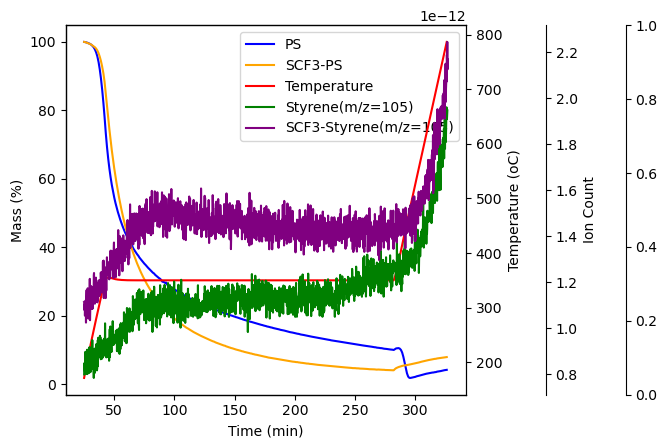

In [33]:
# Mass loss (y-axis) vs time (x-axis) plot of the TGA data
fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))

p1 = ax.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Mass/pct'], color="b", label='PS')
p2 = twin1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="r", label='Temperature')
p3 = twin2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:105)/A'], color="g", label='Styrene(m/z=105)')
# p4 = twin3.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['TIC(scan:1)/A'], color="y", label='Total Ion Count')

p1 = ax.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['Mass/pct'], color="orange", label='SCF3-PS')
p3 = twin2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:105)/A'], color="purple", label='SCF3-Styrene(m/z=105)')
# p4 = twin3.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['TIC(scan:1)/A'], color="y", label='Total Ion Count')

# Create a legend for all the lines
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin1.get_legend_handles_labels()
lines3, labels3 = twin2.get_legend_handles_labels()
# lines4, labels4 = twin3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

# Set x and y axis labels
ax.set_xlabel('Time (min)')
ax.set_ylabel('Mass (%)')
twin1.set_ylabel('Temperature (oC)')
twin2.set_ylabel('Ion Count')

# Set colors for the axis labels



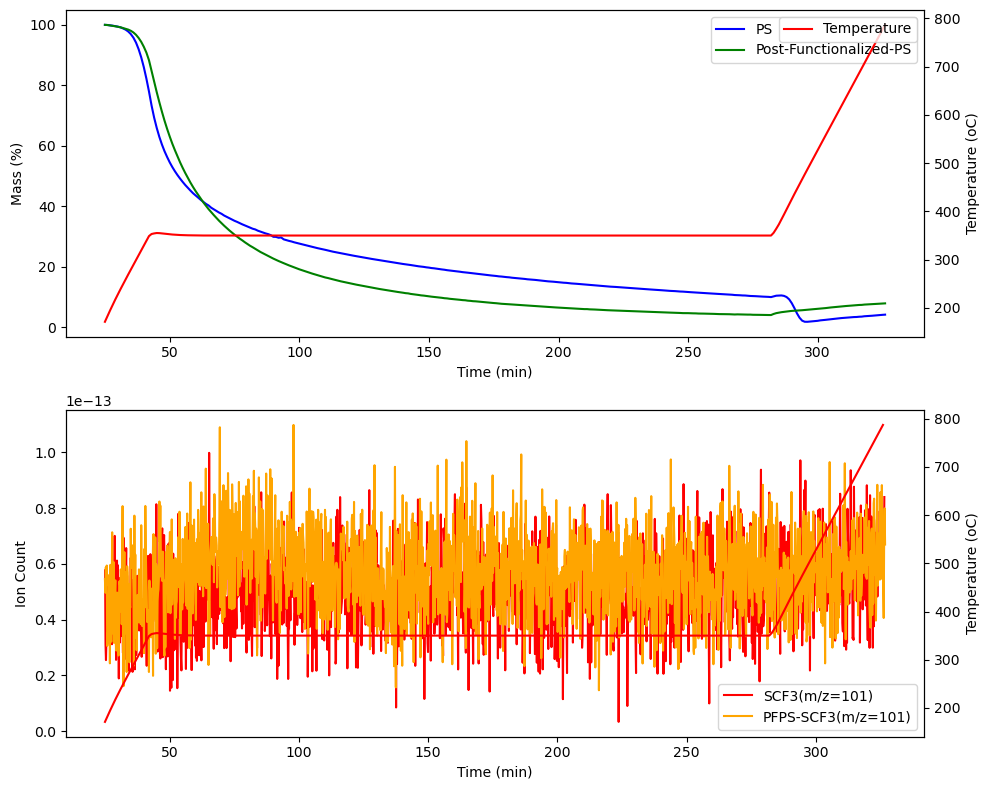

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# TGA data subplot
twin1 = ax1.twinx()
ax1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Mass/pct'], color="b", label='PS')
ax1.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['Mass/pct'], color="green", label='Post-Functionalized-PS')
twin1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="r", label='Temperature')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Mass (%)')
twin1.set_ylabel('Temperature (oC)')
ax1.legend()
twin1.legend(loc=1)

# MS data subplot
twin2 = ax2.twinx()
ax2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:105)/A'], color="b", label='Styrene(m/z=105)')
ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:105)/A'], color="green", label='Post-Functionalized-Styrene(m/z=105)')
# ax2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:101)/A'], color="r", label='SCF3(m/z=101)')
# ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:101)/A'], color="orange", label='PFPS-SCF3-Styrene(m/z=205)')
# ax2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:101)/A'], color="y", label='SCF3(m/z=101)')
# ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:101)/A'], color="purple", label='SCF3(m/z=101)')
# ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:56)/A'], color="purple", label='SCF3(m/z=101)')
twin2.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="r", label='Temperature')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Ion Count')
twin2.set_ylabel('Temperature (oC)')
ax2.legend()

plt.tight_layout()
plt.show()